# 1. Import and Install Dependencies

## 1.1 Install Dependencies

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

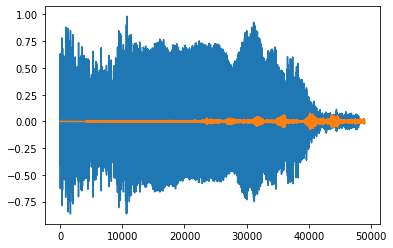

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [6]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [8]:
pos.as_numpy_iterator().next() 

b'data\\Parsed_Capuchinbird_Clips\\XC216012-10.wav'

## 3.3 Add labels and Combine Positive and Negative Samples

Concatenate two different files inline and we pass our existing file paths and give it as '1' for positive sample and '0' if we get a negative sample

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [10]:
tf.ones(len(pos)).shape

TensorShape([217])

In [11]:
positives.as_numpy_iterator().next() ,negatives.as_numpy_iterator().next() 

((b'data\\Parsed_Capuchinbird_Clips\\XC178168-5.wav', 1.0),
 (b'data\\Parsed_Not_Capuchinbird_Clips\\sparrow-sound-effect-17.wav', 0.0))

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [12]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [13]:
os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips'))

['XC114131-0.wav',
 'XC114131-1.wav',
 'XC114131-2.wav',
 'XC114131-3.wav',
 'XC114131-4.wav',
 'XC114132-0.wav',
 'XC114132-1.wav',
 'XC114132-2.wav',
 'XC114132-3.wav',
 'XC114132-4.wav',
 'XC114132-5.wav',
 'XC114132-6.wav',
 'XC119294-0.wav',
 'XC16803-0.wav',
 'XC16803-1.wav',
 'XC16803-2.wav',
 'XC16804-0.wav',
 'XC16804-1.wav',
 'XC168899-0.wav',
 'XC178167-0.wav',
 'XC178167-1.wav',
 'XC178167-2.wav',
 'XC178167-3.wav',
 'XC178168-0.wav',
 'XC178168-1.wav',
 'XC178168-2.wav',
 'XC178168-3.wav',
 'XC178168-4.wav',
 'XC178168-5.wav',
 'XC178168-6.wav',
 'XC178168-7.wav',
 'XC201990-0.wav',
 'XC201990-1.wav',
 'XC201990-2.wav',
 'XC201990-3.wav',
 'XC201990-4.wav',
 'XC201990-5.wav',
 'XC216010-0.wav',
 'XC216010-1.wav',
 'XC216010-2.wav',
 'XC216010-3.wav',
 'XC216010-4.wav',
 'XC216010-5.wav',
 'XC216010-6.wav',
 'XC216010-7.wav',
 'XC216012-0.wav',
 'XC216012-1.wav',
 'XC216012-10.wav',
 'XC216012-11.wav',
 'XC216012-12.wav',
 'XC216012-13.wav',
 'XC216012-14.wav',
 'XC216012-1

## 4.2 Calculate Mean, Min and Max

In [14]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [15]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [17]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

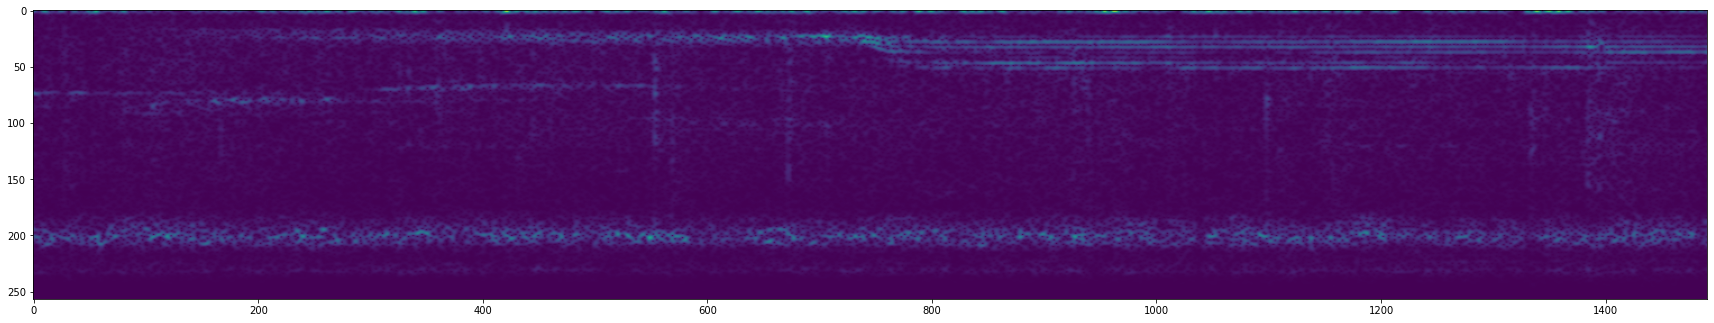

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [21]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=100)
# data = data.batch(16)
data = data.batch(4)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [22]:
len(data)*0.7

142.1

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(4, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D

In [27]:
samples.shape

(4, 1491, 257, 1)

## 7.2 Build Sequential Model, Compile and View Summary

In [28]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

# View the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 744, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 742, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 371, 62, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 369, 60, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 184, 30, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 706560)            0

In [29]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
# model.add(Dropout(0.2))
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(2, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Set the batch size
# # batch_size = 2

# model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

# hist = model.fit(train, epochs=4,batch_size = 1, validation_data=test)


In [30]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1489, 255, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 744, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 742, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 371, 62, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 369, 60, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 184, 30, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 706560)            0

## 7.3 Fit Model, View Loss and KPI Plots

In [32]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 26s 185ms/step - loss: 2.6886 - recall_1: 0.9930 - precision_1: 0.9860 - val_loss: 64.6847 - val_recall_1: 1.0000 - val_precision_1: 0.5500
Epoch 2/4
36/36 [==============================] - 7s 161ms/step - loss: 0.8865 - recall_1: 1.0000 - precision_1: 0.9653 - val_loss: 2.6686 - val_recall_1: 1.0000 - val_precision_1: 0.5167
Epoch 3/4
36/36 [==============================] - 7s 161ms/step - loss: 1.1021 - recall_1: 0.9854 - precision_1: 0.9507 - val_loss: 0.9949 - val_recall_1: 1.0000 - val_precision_1: 0.5833
Epoch 4/4
36/36 [==============================] - 7s 166ms/step - loss: 0.1993 - recall_1: 0.9787 - precision_1: 0.9787 - val_loss: 1.6323 - val_recall_1: 1.0000 - val_precision_1: 0.5667


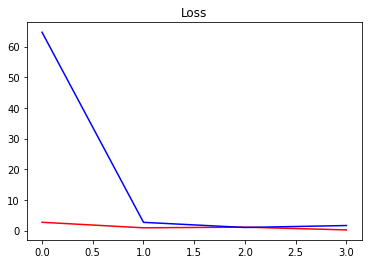

In [33]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

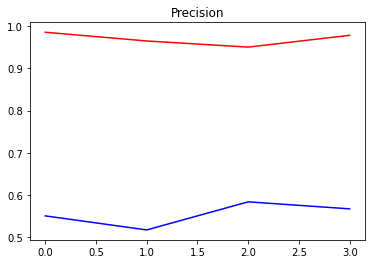

In [34]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

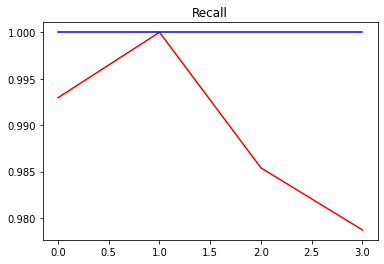

In [35]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [36]:
X_test, y_test = test.as_numpy_iterator().next()

In [37]:
yhat = model.predict(X_test)

## 8.2 Convert Logits to Classes 

In [38]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [39]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [40]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [41]:
wav = load_mp3_16k_mono(mp3)

In [42]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [43]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [44]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [45]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [48]:
yhat = model.predict(audio_slices)

ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,1489,255] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-46-870feeed5f83>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_15653]

Function call stack:
predict_function


In [47]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

ResourceExhaustedError:  OOM when allocating tensor with shape[64,32,1489,255] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-46-870feeed5f83>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_15653]

Function call stack:
predict_function


## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])